In [1]:
import tensorflow.keras.backend as K
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from glob import glob
from copy import deepcopy
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import resnet50

In [2]:
from fl_tissue_model_tools import data_prep, dev_config, models, defs
import fl_tissue_model_tools.preprocessing as prep

In [3]:
dirs = dev_config.get_dev_directories("../dev_paths.txt")

In [4]:
root_data_path = f"{dirs.data_dir}/invasion_data/development"
resnet_inp_shape = (128, 128, 3)
# Binary classification -> only need 1 output unit
n_outputs = 1
val_split = 0.2
batch_size = 32
# n_epochs = 10
frozen_epochs = 20
fine_tune_epochs = 10
fine_tune_lr = 1e-5
seed = 123
class_labels = {"no_invasion": 0, "invasion": 1}

# Early stopping
es_criterion = "val_loss"
es_mode = "min"
# Update these depending on seriousness of experiment
es_patience = 10
es_min_delta = 0.0001

# Model saving
cp_criterion = "val_loss"
cp_mode = "min"
cp_frozen_filepath = "./invasion_depth_v1_output/resnet50_invasion_depth_best_frozen_weights.h5"
cp_fine_tune_filepath = "./invasion_depth_v1_output/resnet50_invasion_depth_best_fine_tune_weights.h5"
cp_best_only = True
# Need to set to True otherwise base model "layer" won't save/load properly
cp_weights_only = True

In [5]:
def balanced_class_weights_from_counts(d):
    n = np.sum(list(d.values()))
    n_c = len(d.keys())
    weights = {}
    for ci, n_ci in d.items():
        weights[ci] = n / (n_c * n_ci)
    return weights

# Prep for loading data

In [6]:
rs = np.random.RandomState(seed)

In [7]:
# img_paths = {k: glob(f"{root_data_path}/train/{k}/*.tif") for k in class_labels.keys()}
# img_counts = {c: len(pn) for c, pn in img_paths.items()}
# class_weights = balanced_class_weights_from_counts(img_counts)
data_paths = {v: glob(f"{root_data_path}/train/{k}/*.tif") for k, v in class_labels.items()}
for k, v in data_paths.items():
    rs.shuffle(v)

In [32]:
data_counts = {k: len(v) for k, v in data_paths.items()}
val_counts = {k: v * val_split for k, v in data_counts.items()}
train_counts = {k: v - val_counts[k] for k, v in data_counts.items()}
train_class_weights = balanced_class_weights_from_counts(train_counts)

In [33]:
data_counts

{0: 371, 1: 34}

In [34]:
train_class_weights

{0: 0.545822102425876, 1: 5.955882352941177}

In [12]:
train_data_paths = {k: v[val_counts[k]:] for k, v in data_paths.items()}
val_data_paths = {k: v[:val_counts[k]] for k, v in data_paths.items()}

# Datasets

In [13]:
class InvasionDataGenerator(Sequence):
    def __init__(self, data_paths, class_labels, batch_size, img_shape, random_state, class_weights=None, shuffle=True, augmentation_function=None):
        self.data_paths = deepcopy(data_paths)
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.class_labels = deepcopy(class_labels)
        self.class_paths = {}
        self.class_counts = {}
        self.img_paths = []
        self.img_labels = []
        self.shuffle = shuffle
        self.rs = random_state
        self.augmentation_function = augmentation_function
        self._get_paths_and_counts(data_paths)
        self.indices = np.arange(len(self.img_paths), dtype=np.uint)
        if class_weights != None:
            self.class_weights = deepcopy(class_weights)
        else:
            self.class_weights = None
        self.shuffle_indices()

    def __len__(self):
        # return len()
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, index):        
        batch_idx_start = index * self.batch_size
        batch_idx_end = batch_idx_start + batch_size
        batch_indices = self.indices[batch_idx_start: batch_idx_end]

        img_paths = [self.img_paths[i] for i in batch_indices]
        # Should it be (B,) or (B,1)?
        y = np.array([self.img_labels[i] for i in batch_indices])

        # Generate data
        # X = np.array([self.prep_image(ip) for ip in img_paths])
        X = self.prep_images(img_paths)
        
        if self.augmentation_function != None:
            X = self.augmentation_function(X, self.rs, expand_dims=False)
        
        if self.class_weights != None:
            # Weight classes by relative proportions in the training set
            w = np.array([self.class_weights[y_] for y_ in y])
            return X, y, w

        return X, y

    
    def _get_paths_and_counts(self, data_paths):
        # self.class_paths = {v: glob(f"{self.datapath}/{k}/*.tif") for k, v in self.class_labels.items()}
        self.class_paths = deepcopy(data_paths)
        self.class_counts = {c: len(pn) for c, pn in self.class_paths.items()}
        for k, v in self.class_paths.items():
            # Paths to each image
            self.img_paths.extend(v)
            # Associate labels with each image path
            self.img_labels.extend(list(np.repeat(k, len(v))))
            
    def shuffle_indices(self):
        # print("shuffling")
        self.rs.shuffle(self.indices)
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_paths), dtype=np.uint)
        if self.shuffle == True:
            self.shuffle_indices()

    def prep_images(self, paths):
        imgs = np.zeros((self.batch_size,) + self.img_shape + (3,))
        for i, path in enumerate(paths):
            img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
            # img = prep.min_max_(cv2.resize(img, self.img_shape, cv2.INTER_LANCZOS4).astype(np.float32), 0, 1, defs.TIF_MIN, defs.TIF_MAX)
            img = prep.min_max_(cv2.resize(img, self.img_shape, cv2.INTER_LANCZOS4).astype(np.float32), defs.GS_MIN, defs.GS_MAX, defs.TIF_MIN, defs.TIF_MAX)
            img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
            imgs[i] = img
        return resnet50.preprocess_input(imgs)
        # return imgs

In [14]:
# # With class weights
train_datagen = InvasionDataGenerator(train_data_paths, class_labels, batch_size, resnet_inp_shape[:2], rs, class_weights=train_class_weights, augmentation_function=prep.augment_imgs)
val_datagen = InvasionDataGenerator(val_data_paths, class_labels, batch_size, resnet_inp_shape[:2], rs, class_weights=train_class_weights, augmentation_function=prep.augment_imgs)
# Without class weights
# train_datagen = InvasionDataGenerator(train_data_paths, class_labels, batch_size, resnet_inp_shape[:2], rs, augmentation_function=prep.augment_imgs)
# val_datagen = InvasionDataGenerator(val_data_paths, class_labels, batch_size, resnet_inp_shape[:2], rs, augmentation_function=prep.augment_imgs)

In [15]:
Xi, yi, wi = train_datagen[1]
# Xi, yi = train_datagen[1]

In [16]:
Xi[0].shape

(128, 128, 3)

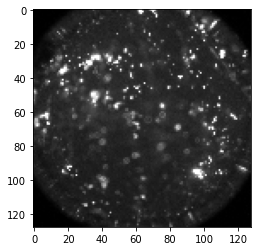

In [17]:
plt.imshow(Xi[0][:, :, 0], cmap="gray")

# Model

In [18]:
K.clear_session()

In [19]:
tl_model = models.build_ResNet50_TL(
    n_outputs,
    resnet_inp_shape,
    # base_last_layer="conv5_block3_out",
    # base_last_layer="conv5_block2_out",
    # base_last_layer="conv5_block1_out",
    base_last_layer="conv4_block6_out",
    # base_last_layer="conv3_block4_out",
    # Switch to softmax once n_outputs > 1
    output_act="sigmoid",
    base_model_trainable=False
)
tl_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [20]:
tl_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
base_model (Functional)      (None, 8, 8, 1024)        8589184   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 8,590,209
Trainable params: 1,025
Non-trainable params: 8,589,184
_________________________________________________________________


In [21]:
es_callback = EarlyStopping(monitor=es_criterion, mode=es_mode, min_delta=es_min_delta, patience=es_patience)
cp_callback = ModelCheckpoint(cp_frozen_filepath, monitor=cp_criterion, mode=cp_mode, save_best_only=cp_best_only, save_weights_only=cp_weights_only)

In [22]:
h1 = tl_model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=frozen_epochs,
    callbacks=[es_callback, cp_callback]
)

Epoch 1/20
10/10 [==============================] - 10s 459ms/step - loss: 0.7504 - binary_accuracy: 0.2937 - val_loss: 0.5349 - val_binary_accuracy: 0.5312
Epoch 2/20
10/10 [==============================] - 4s 353ms/step - loss: 0.6752 - binary_accuracy: 0.8188 - val_loss: 0.5353 - val_binary_accuracy: 0.8906
Epoch 3/20
10/10 [==============================] - 4s 360ms/step - loss: 0.6208 - binary_accuracy: 0.8219 - val_loss: 0.6802 - val_binary_accuracy: 0.6719
Epoch 4/20
10/10 [==============================] - 4s 346ms/step - loss: 0.5944 - binary_accuracy: 0.5906 - val_loss: 0.6192 - val_binary_accuracy: 0.5469
Epoch 5/20
10/10 [==============================] - 4s 362ms/step - loss: 0.5512 - binary_accuracy: 0.7531 - val_loss: 0.4708 - val_binary_accuracy: 0.8906
Epoch 6/20
10/10 [==============================] - 4s 347ms/step - loss: 0.5688 - binary_accuracy: 0.7875 - val_loss: 0.5519 - val_binary_accuracy: 0.7031
Epoch 7/20
10/10 [==============================] - 4s 351ms/st

# Load best frozen weights before fine tuning

In [23]:
tl_model.load_weights(cp_frozen_filepath)

# Train model (all layers)

In [24]:
# Make base model trainable (leave layers in inference mode)
models.toggle_TL_freeze(tl_model)

In [25]:
tl_model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [26]:
tl_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
base_model (Functional)      (None, 8, 8, 1024)        8589184   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 8,590,209
Trainable params: 8,559,617
Non-trainable params: 30,592
_________________________________________________________________


In [27]:
es_callback = EarlyStopping(monitor=es_criterion, mode=es_mode, min_delta=es_min_delta, patience=es_patience)
cp_callback = ModelCheckpoint(cp_fine_tune_filepath, monitor=cp_criterion, mode=cp_mode, save_best_only=cp_best_only, save_weights_only=cp_weights_only)

In [28]:
h2 = tl_model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=fine_tune_epochs,
    callbacks=[es_callback, cp_callback]
)

Epoch 1/10
10/10 [==============================] - 11s 457ms/step - loss: 0.4505 - binary_accuracy: 0.8125 - val_loss: 0.4310 - val_binary_accuracy: 0.6875
Epoch 2/10
10/10 [==============================] - 4s 346ms/step - loss: 0.4161 - binary_accuracy: 0.7125 - val_loss: 0.4591 - val_binary_accuracy: 0.9062
Epoch 3/10
10/10 [==============================] - 4s 348ms/step - loss: 0.3687 - binary_accuracy: 0.8406 - val_loss: 0.3237 - val_binary_accuracy: 0.8281
Epoch 4/10
10/10 [==============================] - 4s 353ms/step - loss: 0.3543 - binary_accuracy: 0.7875 - val_loss: 0.2945 - val_binary_accuracy: 0.8750
Epoch 5/10
10/10 [==============================] - 4s 354ms/step - loss: 0.3305 - binary_accuracy: 0.8438 - val_loss: 0.2938 - val_binary_accuracy: 0.7812
Epoch 6/10
10/10 [==============================] - 4s 353ms/step - loss: 0.3191 - binary_accuracy: 0.7781 - val_loss: 0.2927 - val_binary_accuracy: 0.9375
Epoch 7/10
10/10 [==============================] - 4s 352ms/st